In [ ]:
import pandas as pd

In [ ]:
dict_ = {'comand':['Martha', 'Tim', 'Rob', 'Georgia'],
        'val':[0, 91, 1, 95]
       }

df = pd.DataFrame(dict_)

display(df)

df.loc[len(df.index)] = ['Amy', 89]

display(df)

,comand,val
0,Martha,0
1,Tim,91
2,Rob,1
3,Georgia,95


,comand,val
0,Martha,0
1,Tim,91
2,Rob,1
3,Georgia,95
4,Amy,89


In [ ]:
df[1:3]

,comand,val
1,Tim,91
2,Rob,1


In [ ]:
pd_s_count = df['comand'].value_counts()

In [ ]:
pd_s_count

Martha     1
Tim        1
Rob        1
Georgia    1
Amy        1
Name: comand, dtype: int64

In [ ]:
pd_s_count.index[pd_s_count.min()]

'Tim'

In [ ]:
int(df['val'][df.shape[0] - 1]) + 1

KeyError: ignored

In [ ]:
df.to_csv('test.txt', index=False)

In [ ]:
df = pd.read_csv('test.txt')

In [ ]:
for d in df:
  print(d)

comand
val


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD

import keras

In [ ]:
# Load CIFAR10 data
(X, y), (_, _) = keras.datasets.cifar10.load_data()

X = X[y.flatten() == 8]

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
# Input shape
image_shape = (32, 32, 3)

latent_dimensions = 100

In [ ]:
def build_generator():

		model = Sequential()

		model.add(Dense(128 * 8 * 8, activation="relu",
						input_dim=latent_dimensions))
		model.add(Reshape((8, 8, 128)))

		model.add(UpSampling2D())

		model.add(Conv2D(128, kernel_size=3, padding="same"))
		model.add(BatchNormalization(momentum=0.78))
		model.add(Activation("relu"))

		model.add(UpSampling2D())

		model.add(Conv2D(64, kernel_size=3, padding="same"))
		model.add(BatchNormalization(momentum=0.78))
		model.add(Activation("relu"))

		model.add(Conv2D(3, kernel_size=3, padding="same"))
		model.add(Activation("tanh"))


		# Output image
		noise = Input(shape=(latent_dimensions,))
		image = model(noise)

		return Model(noise, image)


In [ ]:
def build_discriminator(): #

		model = Sequential()

		model.add(Conv2D(32, kernel_size=3, strides=2,
						input_shape=image_shape, padding="same"))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.25))

		model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
		model.add(ZeroPadding2D(padding=((0,1),(0,1))))
		model.add(BatchNormalization(momentum=0.82))
		model.add(LeakyReLU(alpha=0.25))
		model.add(Dropout(0.25))

		model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
		model.add(BatchNormalization(momentum=0.82))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.25))

		model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
		model.add(BatchNormalization(momentum=0.8))
		model.add(LeakyReLU(alpha=0.25))
		model.add(Dropout(0.25))

		# Building the O/P layer
		model.add(Flatten())
		model.add(Dense(1, activation='sigmoid'))

		image = Input(shape=image_shape)
		validity = model(image)

		return Model(image, validity)


In [ ]:
def display_images():
		r, c = 4,4
		noise = np.random.normal(0, 1, (r * c,latent_dimensions))
		generated_images = generator.predict(noise)

		#
		generated_images = 0.5 * generated_images + 0.5

		fig, axs = plt.subplots(r, c)
		count = 0
		for i in range(r):
			for j in range(c):
				axs[i,j].imshow(generated_images[count, :,:,])
				axs[i,j].axis('off')
				count += 1
		plt.show()
		plt.close()


In [ ]:
# Discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
					optimizer=Adam(0.0002,0.5),
					metrics=['accuracy'])

discriminator.trainable = False

# Generator
generator = build_generator()

z = Input(shape=(latent_dimensions,))
image = generator(z)

valid = discriminator(image)

combined_network = Model(z, valid)
combined_network.compile(loss='binary_crossentropy',
						optimizer=Adam(0.0002,0.5))


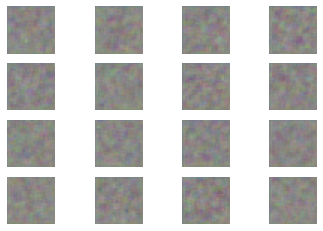

In [ ]:
# Set the parameters & Train the Network
num_epochs=150
batch_size=32
display_interval=2500
losses=[]

# Normalizing the input
X = (X / 127.5) - 1.

valid = np.ones((batch_size, 1))

# Add some noise
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(num_epochs):

			#Sampling a random half of images
			index = np.random.randint(0, X.shape[0], batch_size)
			images = X[index]

			noise = np.random.normal(0, 1, (batch_size, latent_dimensions))
			generated_images = generator.predict(noise)

			discm_loss_real = discriminator.train_on_batch(images, valid)
			discm_loss_fake = discriminator.train_on_batch(generated_images, fake)
			discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake)

			genr_loss = combined_network.train_on_batch(noise, valid)


			if epoch % display_interval == 0:
				display_images()


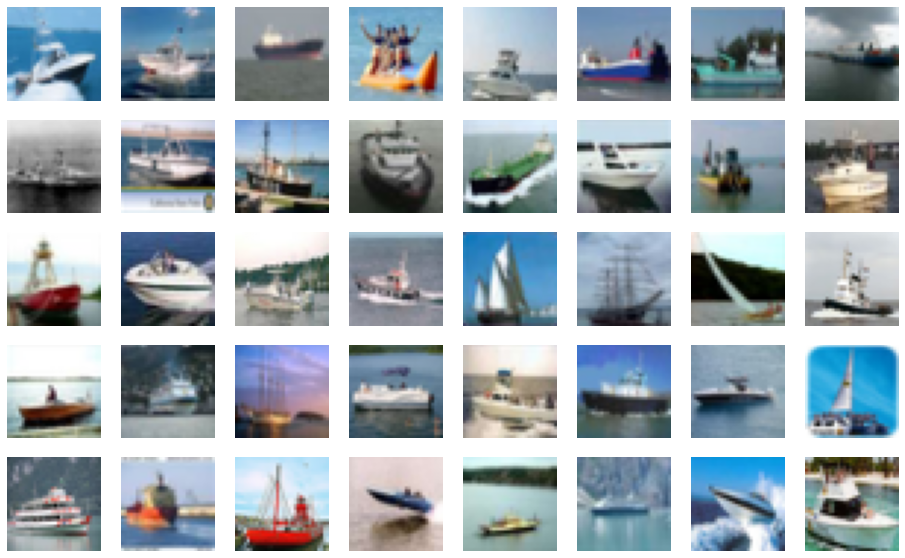

In [ ]:
#Plotting some of the original images
s=X[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, image in enumerate(s):
	ax[i//8, i%8].imshow(image)
	ax[i//8, i%8].axis('off')

plt.show()


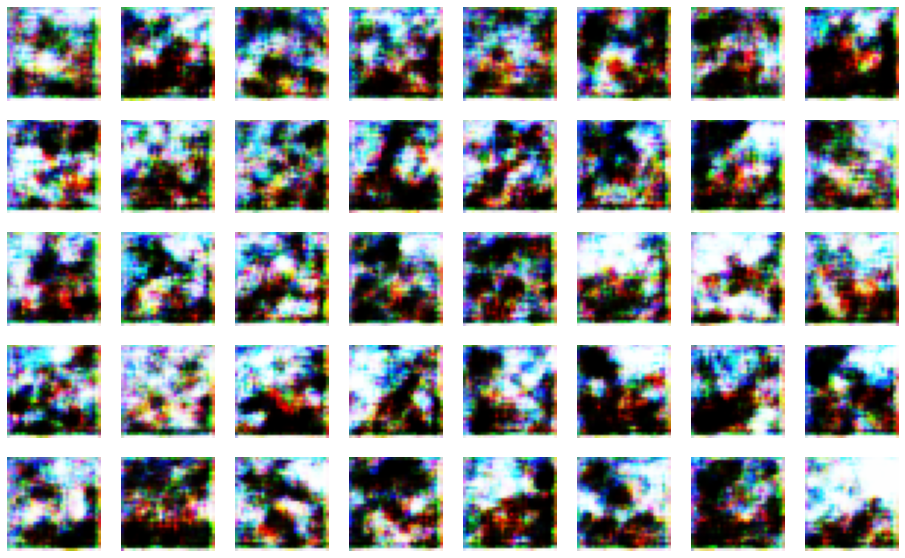

In [ ]:
#Plotting some of the last batch of generated images
noise = np.random.normal(size=(40, latent_dimensions))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, image in enumerate(generated_images):
	ax[i//8, i%8].imshow(image)
	ax[i//8, i%8].axis('off')

plt.show()
